<a href="https://colab.research.google.com/github/kecosz/EcohNet/blob/main/ecohnet_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EcohNet
This notebook shows an example of execution and visualization of the script version.  

9/28/2023  
version 0.12  

### Clone EcohNet_py repository

In [1]:
!git clone https://github.com/kecosz/EcohNet_py.git

Cloning into 'EcohNet_py'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 113 (delta 11), reused 1 (delta 1), pack-reused 87
Receiving objects: 100% (113/113), 1.16 MiB | 4.39 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
!ls

EcohNet_py  sample_data


### Setup environment

In [3]:
import sys
# change both paths
REPO_PATH='/content/EcohNet_py/src'
%cd EcohNet_py/
sys.path.append(REPO_PATH)
!pip install -e .

/content/EcohNet_py
Obtaining file:///content/EcohNet_py
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.4 MB/s eta 0:00:00
  Running setup.py develop for EcohNet


In [4]:
# By default, 10000 ESNs are used for evaluation, but a different number can be specified by the option -rep as follows
!python scripts/run_ecohnet.py -rep 100

   SRP  ...  Wind speed
0    1  ...         2.3
1    1  ...         2.6
2   20  ...         2.5
3    3  ...         2.5

[4 rows x 17 columns]
['0 SRP',
 '1 NO3-N',
 '2 Large_cladocera',
 '3 Small_cladocera',
 '4 Rotifers',
 '5 Calanoida',
 '6 Cyclopoida',
 '7 Microcystis',
 '8 Oscillatoriales',
 '9 Nostocales',
 '10 Aulacoseira',
 '11 Thalassiosiraceae',
 '12 Fragilaria',
 '13 Nitzschia',
 '14 Temperature',
 '15 Precipitation',
 '16 Wind speed']
RCcore: 100% 17/17 [12:37<00:00, 44.58s/it, links=5, elapsed=34.70 s]
RCprd: 100% 17/17 [00:13<00:00,  1.28it/s]
RCmat: 100% 17/17 [00:49<00:00,  2.91s/it]
elapsed time of RCall: 820.8174359798431


In [5]:
!ls out

rdata_011322_2.csv_100_20231002.dill


In [8]:
import dill
rcall = dill.load(open('out/rdata_011322_2.csv_100_20231002.dill','rb'))

In [10]:
(rcc, rcprd, rcmat, rw, datk) = rcall

#### Setup modules for visualization  

In [13]:
from __future__ import annotations
import os
import re
import pprint
import time
import itertools
from pathlib import Path

import dill
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.kde import KDEUnivariate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib import gridspec
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
from graphviz import Digraph
from IPython.core.display import HTML

from ecohnet.utils.preprocess import std
from ecohnet import RCmat, RCprd, RCsetup, RCcore, RCall
matplotlib.rcParams['figure.dpi'] = 100

/content/EcohNet_py/src/ecohnet/rc_all.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [25]:
rdata = pd.read_csv("data/rdata_011322_2.csv", header=0)
pprint.pprint([f"{i} {col}" for i, col in enumerate(rdata.columns)])
labels = rdata.columns.to_list()

['0 SRP',
 '1 NO3-N',
 '2 Large_cladocera',
 '3 Small_cladocera',
 '4 Rotifers',
 '5 Calanoida',
 '6 Cyclopoida',
 '7 Microcystis',
 '8 Oscillatoriales',
 '9 Nostocales',
 '10 Aulacoseira',
 '11 Thalassiosiraceae',
 '12 Fragilaria',
 '13 Nitzschia',
 '14 Temperature',
 '15 Precipitation',
 '16 Wind speed']


Now, a matrix of unique predictive skills is obtained. In the following, it is saved as "upsmatrix.csv" in the session folder.

In [29]:
columns = [column + "->" for column in labels]
index = ["->" + column for column in labels]
upsmatrix = pd.DataFrame.from_records(rcmat[0], index=index, columns=columns)
upsmatrix.to_csv("upsmatrix.csv")
pd.DataFrame.from_records(rcmat[0], index=index, columns=columns)

,SRP->,NO3-N->,Large_cladocera->,Small_cladocera->,Rotifers->,Calanoida->,Cyclopoida->,Microcystis->,Oscillatoriales->,Nostocales->,Aulacoseira->,Thalassiosiraceae->,Fragilaria->,Nitzschia->,Temperature->,Precipitation->,Wind speed->
->SRP,0.002838,0.000000,0.000000,0.000000,0.000000,0.008207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011141,0.000000,0.010826
->NO3-N,0.000000,0.035605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045752,0.000000,0.000000
->Large_cladocera,0.000000,0.003786,0.000726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002417,0.000000,0.014012,0.000000,0.000000
->Small_cladocera,0.000000,0.000000,0.026889,0.017813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021614,0.005989,0.000000,0.000000,0.000000
->Rotifers,0.000000,0.000000,0.000000,0.000000,0.045792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014134,0.000000,0.000000
->Calanoida,0.000000,0.002123,0.000000,0.000000,0.000000,-0.006080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005091,0.000000,0.003875
->Cyclopoida,0.000000,0.000000,0.009111,0.000000,0.000000,0.000000,-0.003669,0.000000,0.008649,0.000000,0.000000,0.000000,0.000000,0.000000,0.011390,0.000000,0.000000
->Microcystis,0.000000,0.006472,0.000000,0.000000,0.000000,0.009158,0.000000,-0.000457,0.000000,0.003453,0.000000,0.000000,0.006036,0.000000,0.000000,0.000000,0.000000
->Oscillatoriales,0.000000,0.008768,0.000000,0.000000,0.005755,0.000000,0.000000,0.000000,0.017924,0.016063,0.000000,0.000000,0.000000,0.002362,0.000000,0.000000,0.000000
->Nostocales,0.007258,0.011548,0.008560,0.000000,0.007335,0.000000,0.005485,0.000000,0.000000,0.012355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The second element of `rcmat` represents, in matrix form, the proportion of trials for which the addition of the variables in row did not improve the prediction, and can be used as a criterion for adopting causal relationships.

In [27]:
pd.DataFrame.from_records(rcmat[1], index=index, columns=columns)

,SRP->,NO3-N->,Large_cladocera->,Small_cladocera->,Rotifers->,Calanoida->,Cyclopoida->,Microcystis->,Oscillatoriales->,Nostocales->,Aulacoseira->,Thalassiosiraceae->,Fragilaria->,Nitzschia->,Temperature->,Precipitation->,Wind speed->
->SRP,0.490405,1.000000,1.000000,1.000000,1.000000,0.425911,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.389591,1.000000,0.393559
->NO3-N,1.000000,0.104586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.057596,1.000000,1.000000
->Large_cladocera,1.000000,0.420211,0.472317,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.443474,1.000000,0.252358,1.000000,1.000000
->Small_cladocera,1.000000,1.000000,0.189725,0.295199,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.249372,0.442354,1.000000,1.000000,1.000000
->Rotifers,1.000000,1.000000,1.000000,1.000000,0.000395,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.226192,1.000000,1.000000
->Calanoida,1.000000,0.446163,1.000000,1.000000,1.000000,0.662041,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.363584,1.000000,0.397072
->Cyclopoida,1.000000,1.000000,0.312355,1.000000,1.000000,1.000000,0.597756,1.000000,0.320354,1.000000,1.000000,1.000000,1.000000,1.000000,0.275925,1.000000,1.000000
->Microcystis,1.000000,0.401357,1.000000,1.000000,1.000000,0.359326,1.000000,0.530381,1.000000,0.453658,1.000000,1.000000,0.408546,1.000000,1.000000,1.000000,1.000000
->Oscillatoriales,1.000000,0.344452,1.000000,1.000000,0.398155,1.000000,1.000000,1.000000,0.208618,0.232047,1.000000,1.000000,1.000000,0.463031,1.000000,1.000000,1.000000
->Nostocales,0.371119,0.299820,0.348261,1.000000,0.369736,1.000000,0.404253,1.000000,1.000000,0.287503,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Plot upsmatrix as a heatmap

In [30]:
# helper functions for plot heatmap using mathematica's colormap
def _parse_colorlist(text:str) -> list[list[float]]:
    "parse text of color list, exported mathematica"
    pattern = r"(?P<num>\d+\.\d+)(?:,|])"
    colors = []
    color = []
    for match in re.finditer(pattern, text):
        value_text = match.group('num')
        value = float(value_text)
        color.append(value)
        if len(color) == 3:
            colors.append(color)
            color = []
    return colors

def _get_wolfram_lake_color() -> np.ndarray:
    "load LakeColor exported mathematica"
    file_path = Path("/content/EcohNet_py/external/wolfram/LakeColors.txt")
    assert file_path.exists()
    assert file_path.is_file()
    with open(file_path) as f:
        text = f.read()
    colorlist =  _parse_colorlist(text)
    return np.array(colorlist)

def get_cmap_wolfram_Lake() -> LinearSegmentedColormap:
    "Colormap for matplotlib of LakeColor exported mathematica"
    colors = _get_wolfram_lake_color()
    return LinearSegmentedColormap.from_list("Lake", colors, N=len(colors))


def get_two_range_cmap(name: str='wolfram_lake'):
    "colormap with two regions"
    if name=='wolfram_lake':
        higher = _get_wolfram_lake_color()
        lower = np.array([[0,0,0]] * len(higher))
    else:
        higher = plt.colormaps.get(name)(np.linspace(0, 1, 256))
        lower = np.array([[0,0,0,1]] * len(higher))

    colors = np.vstack((lower, higher))
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=len(colors))
    return cmap

# helper class for plot customized color map
class PowerAndLinearNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        higher = np.clip(value, self.vcenter, None)
        higher = 0.6 * (1 - np.sqrt(higher/self.vmax))
        higher = higher / 2 + 1 / 2
        higher = np.clip(higher, 0.5, 1.0)
        lower = np.clip(value, None, self.vcenter)
        lower = np.interp(lower, [self.vmin, self.vcenter], [0., 0.5])

        ret = higher * (value >= self.vcenter) + lower * (value < self.vcenter)
        ret= np.clip(ret, 0.0, 1.0)
        return ret

# helper class for plot customized color map
class PowerNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        ret = 0.6 * (1 - np.sqrt(value/self.vmax))
        return ret

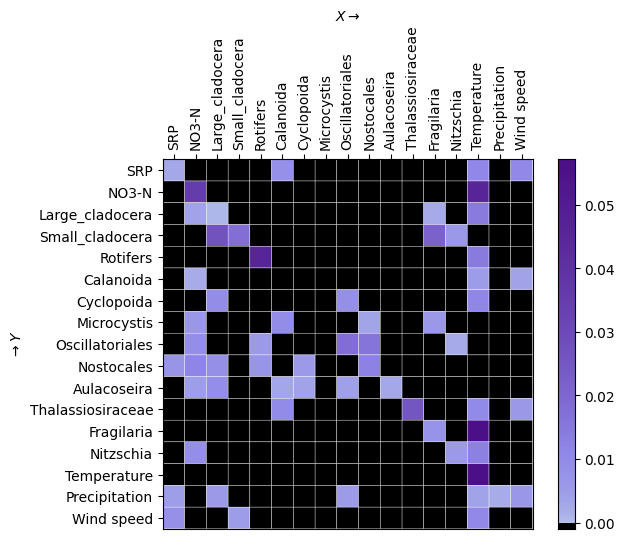

In [31]:
# plot upsmatrix
fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[25,1])
spec.update(wspace=0.025, hspace=0.05)
# color setting
mx = sorted(abs(rcmat[0]).flatten())[-2]
vmin = rcmat[0].min()
colornorm = PowerAndLinearNormalize(vmin=vmin, vcenter=1e-8, vmax=mx)
cmap = get_two_range_cmap(name='wolfram_lake')
# plot heatmap
ax = fig.add_subplot(spec[0])
aximg = ax.pcolor(rcmat[0], norm=colornorm, cmap=cmap, edgecolors='white')
ax.invert_yaxis()
ax.set_aspect("equal")
# labels
ax.set_xlabel(r"$X\rightarrow$")
ax.xaxis.set_label_position('top')
ax.set_ylabel(r"$\rightarrow Y$")
# ticks
tick_l = [i+1/2 for i in range(len(rcmat[0]))]
ax.set(xticks=tick_l, yticks =tick_l)
ax.set_xticklabels(labels, rotation=90)
ax.xaxis.tick_top()
ax.set_yticklabels(labels)
plt.subplots_adjust(right=0.8)
# plot colorbar
vmin = -0.001
vmax = mx
X, Y = np.mgrid[0:1:0.5, vmin:vmax:(vmax-vmin)/512]
ax = fig.add_subplot(spec[1])
ax.yaxis.tick_right()
ax.contourf(X, Y, Y, norm=colornorm, cmap=cmap, levels=512)
ax.get_xaxis().set_visible(False)
plt.show()

### Visualize causal network

In [32]:
thlevel = 0.002
mm = rcmat[0].copy()
mm[rcmat[0] < thlevel] = 0
# edges above threshold
pos = list(zip(*np.where(mm>0)))
# weights of pos
str_ = mm[mm>0]
# labels having edge
lis = [labels[p] for p in set(v for edge in pos for v in edge)]

cmap = get_cmap_wolfram_Lake()
links_int = []
for p, st in zip(pos, str_):
    # thickness
    thickness_coef = 0.8
    if st > 0.01:
        thickness = 4 * thickness_coef
    elif st > 0.005:
        thickness = 2 * thickness_coef
    else:
        thickness = 1 * thickness_coef
    rgba = cmap(0.6*(1-(st/mx)**0.5))
    color = colors.rgb2hex(rgba)
    link = {"src": str(p[0]), "dst": str(p[1]), "thickness": str(thickness), "color": color}
    links_int.append(link)

dg = Digraph(
    format='png',
    engine="dot",
    graph_attr={
        "ranksep": "0.7",
        "splines": "spline",
        "outputorder": "edgesfirst",
        "margin": "0.2"})

dg.attr('node', shape='circle')
for i, label in enumerate(labels):
    dg.node(str(i), label=f"\n\n{label}", fontname="Arial", shape="circle", fixedsize="true",width="0.1", style="filled",fillcolor="#a3b4cc", fontsize="12")
for link in links_int:
    dg.edge(link['dst'], link['src'],
    style="solid",
    color=link["color"],
    penwidth=link['thickness'],
    arrowsize="0.4")

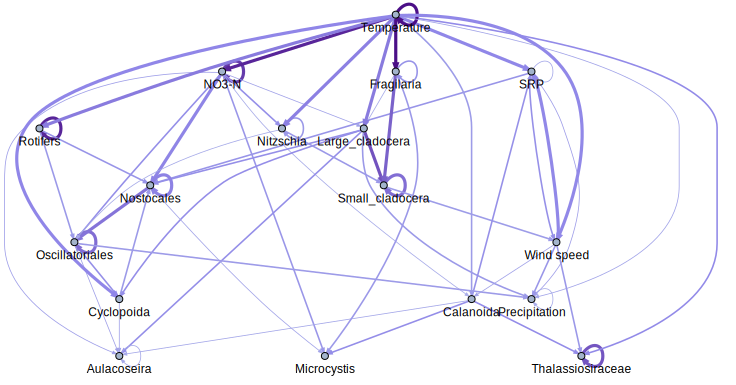

In [33]:
%%capture --no-stdout --no-display cap
# hide stderr (captured into variable 'cap')
dg.render()
dg

## Prediction

The following codes visualize the predicted (red lines and gray shading) and actual (blue lines) values.

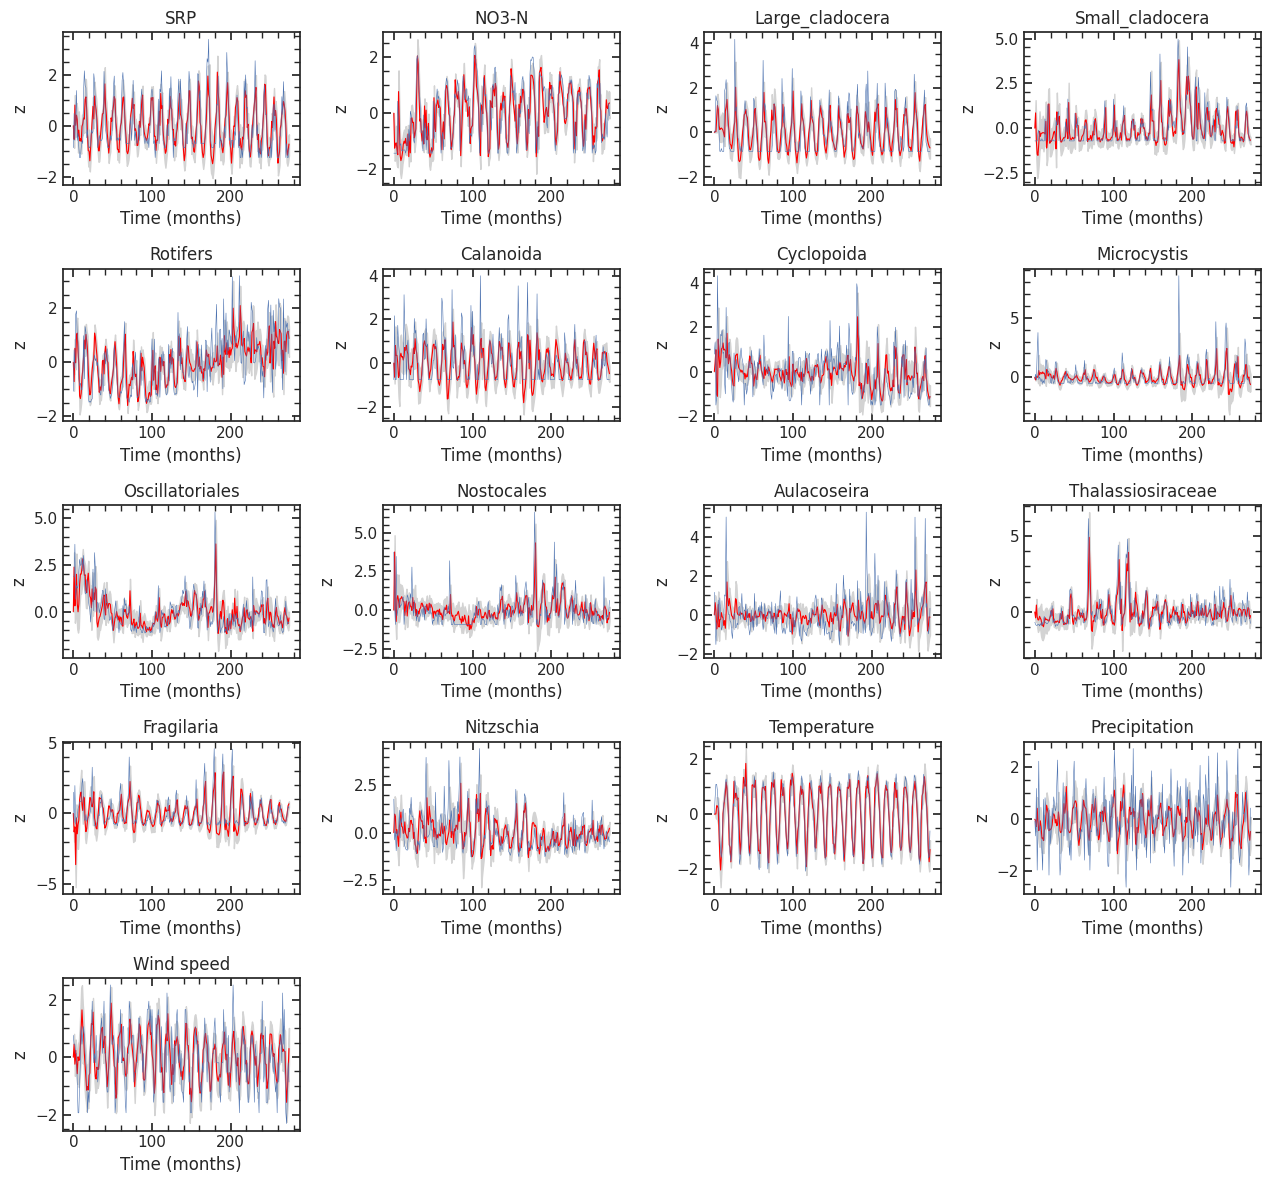

In [34]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(5,4, figsize=(13,12))
for i, ax in enumerate(itertools.chain.from_iterable(axes)):
    if i >= len(rcprd):
        fig.delaxes(ax)
        continue
    ax.set_title(labels[i])
    # ticks
    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # labels
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("z")
    ys = np.transpose(rcprd[i][1])
    x = np.arange(len(ys[0]))
    sns.lineplot(ys[1], color='red', ax=ax, linewidth=0.8)
    ax.fill_between(x,ys[0],ys[2], color='lightgray')

    target = rcprd[i][2]
    sns.lineplot(target, ax=ax, linewidth=0.4)
plt.tight_layout()
plt.show()
# fig.savefig("timeseries.png")

In [35]:
# spearman rank correlation
preds = np.array([[quantiles[1] for quantiles in a_rcprd[1]] for a_rcprd in rcprd])
ys = np.array([a_rcprd[2] for a_rcprd in rcprd])
spearmancorr = [stats.spearmanr(pred, y).statistic for pred, y in zip(preds, ys)] # type: ignore

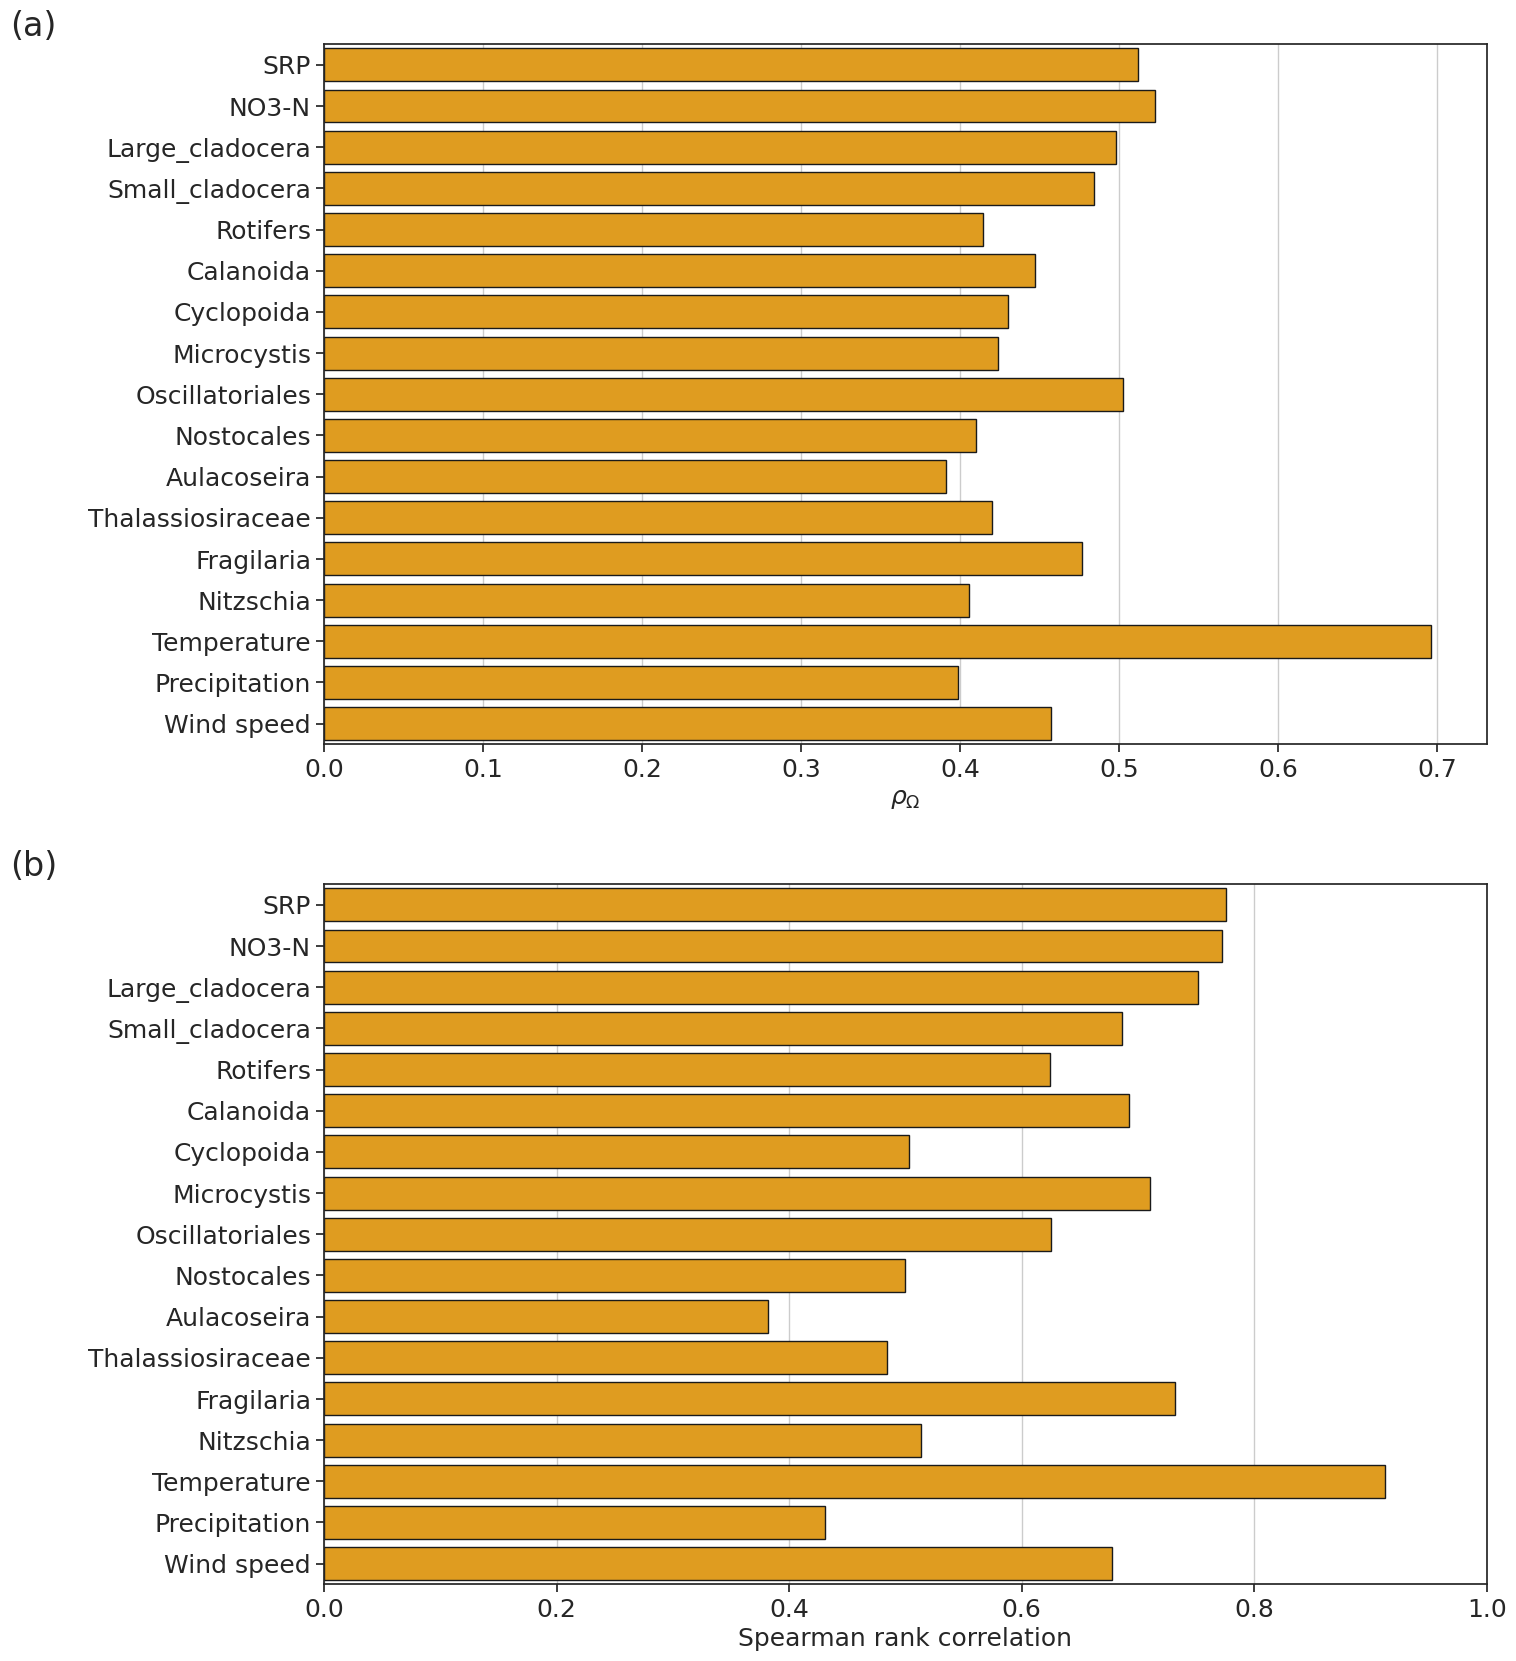

In [36]:
# 1
rcprd_medians = np.array([rcprd_a[0][0] for rcprd_a in rcprd])
sns.set_theme(style="ticks")
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(2,1,1)
sns.barplot(x=rcprd_medians,y=labels,ax=ax, color='orange', edgecolor=".1")
ax.xaxis.grid()
ax.tick_params(labelsize=18)
ax.set_xlabel(r"$\rho_{\Omega}$", fontsize=18)
ax.set_title("(a)", x=-0.25, fontsize=24)
# 2
ax = fig.add_subplot(2,1,2)
sns.barplot(x=spearmancorr,y=labels,ax=ax, color='orange', edgecolor=".1")
ax.xaxis.grid()
ax.set_xlim(0,1)
ax.tick_params(labelsize=18)
ax.set_xlabel("Spearman rank correlation", fontsize=18)
ax.set_title("(b)", x=-0.25, fontsize=24)

plt.show()